In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
import h5py as h5
from PIL import Image
import osr, gdal

ModuleNotFoundError: No module named 'osr'

In [47]:
path_to_h5 = './data/' + 'LC08_L2SP_02_T1_cropped.h5'
path_to_h5_small = './data/' + 'LC08_L2SP_02_T1_cropped_small.h5'

## Функции и классы

In [60]:
def get_coords_from_tif(path):
    # get the existing coordinate system
    ds = gdal.Open(path)
    
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    dx = gt[1]
    dy = -gt[5]
    
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    
    #maxx = gt[0] + width*gt[1] + height*gt[2]
    #maxy = gt[3] 
    centerx = gt[0] + width/2*gt[1] + height/2*gt[2]
    centery = gt[3] + width/2*gt[4] + height/2*gt[5]
    center = (centerx, centery)
    sizes = (width*dx, height*dy)
    return center, sizes

In [108]:
def transorm_point_to_latlong(x,y, path):
    ds = gdal.Open(path)
    
    # projective coordinate system
    old_cs_config = """
    PROJCS["WGS 84 / UTM zone 39N",
        GEOGCS["WGS 84",
            DATUM["WGS_1984",
                SPHEROID["WGS 84",6378137,298.257223563,
                    AUTHORITY["EPSG","7030"]],
                AUTHORITY["EPSG","6326"]],
            PRIMEM["Greenwich",0,
                AUTHORITY["EPSG","8901"]],
            UNIT["degree",0.0174532925199433,
                AUTHORITY["EPSG","9122"]],
            AUTHORITY["EPSG","4326"]],
        PROJECTION["Transverse_Mercator"],
        PARAMETER["latitude_of_origin",0],
        PARAMETER["central_meridian",51],
        PARAMETER["scale_factor",0.9996],
        PARAMETER["false_easting",500000],
        PARAMETER["false_northing",0],
        UNIT["metre",1,
            AUTHORITY["EPSG","9001"]],
        AXIS["Easting",EAST],
        AXIS["Northing",NORTH],
        AUTHORITY["EPSG","32639"]]
    """
    old_cs = osr.SpatialReference()
    old_cs .ImportFromWkt(old_cs_config)
    
    # create the new coordinate system
    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs .ImportFromWkt(wgs84_wkt)
    
    
    # create a transform object to convert between coordinate systems
    transform = osr.CoordinateTransformation(old_cs,new_cs) 
    #get the coordinates in lat long
    latlong = transform.TransformPoint(x,y)
    return latlong

In [112]:
path_to_data = './data/images'
scenes = sorted(os.listdir(path_to_data))
s = scenes[0]
path = path_to_data+'/'+s

data_list = os.listdir(path)
name_tifs = sorted([d for d in data_list if (d.endswith('.TIF') and 'SR_B' in d)])
nt = name_tifs[1]
path_to_tif = path+'/'+ nt

center, sizes = get_coords_from_tif(path_to_tif)

In [113]:
center

(597750.0, 7123200.0)

In [114]:
transorm_point_to_latlong(center[0],center[1], path_to_tif)

(53.01467071125956, 64.2210992689358, 0.0)

In [21]:
def get_angle(image_npy):
    x1_max = 0
    x2_max = 0
    for b in range(7):
        y1 = image_npy.shape[1]-1000
        x1 = np.nonzero(image_npy[:,y1,b])[0][0]
        if x1>x1_max:
            x1_max = x1
        y2 = image_npy.shape[1]-5000
        x2 = np.nonzero(image_npy[:,y2,b])[0][0]
        if x2>x2_max:
            x2_max = x2
    tan = (y1-y2)/(x1_max-x2_max)
    phi_rad = np.pi/2 - np.arctan(tan)
    return phi_rad

In [22]:
def crop_black(new_npy, delta = 200):
    x_min = np.nonzero(new_npy[:,new_npy.shape[1]-5000,0])[0][0]+delta
    x_max = np.nonzero(new_npy[:,new_npy.shape[1]-5000,0])[0][-1]-delta
    y_min = np.nonzero(new_npy[5000,:,0])[0][0]+delta
    y_max = np.nonzero(new_npy[5000,:,0])[0][-1]-delta
    return new_npy[x_min:x_max,y_min:y_max,:]

In [23]:
class numpy_image():
    def __init__(self,s,path_to_data):
        self.path = path_to_data+'/'+s
        data_list = os.listdir(self.path)
        name_tifs = sorted([d for d in data_list if (d.endswith('.TIF') and 'SR_B' in d)])
        scene = []
        for nt in name_tifs:
            path_to_tif = self.path+'/'+ nt  
            with Image.open(path_to_tif) as open_band:
                band = np.array(open_band)
                scene.append(band)
        self.npy = np.array(scene).transpose(1,2,0)
        self.phi_rad = get_angle(self.npy)
        self.phi = self.phi_rad/np.pi * 180
        self.npy = rotate(self.npy, self.phi)
        self.npy = crop_black(self.npy)
        
        self.center, self.sizes = get_coords_from_tif(path_to_tif)
        w = self.sizes[0] #size along x1 axes
        h = self.sizes[1] #size along y1 axes
        self.a = (-h*np.cos(self.phi_rad)+w*np.sin(self.phi_rad))/(np.sin(self.phi_rad)**2-np.cos(self.phi_rad)**2) #size along x2 axes
        self.b = (h*np.sin(self.phi_rad)-w*np.cos(self.phi_rad))/(np.sin(self.phi_rad)**2-np.cos(self.phi_rad)**2) #size along y2 axes
        
        (x2_pixels, y2_pixels) = self.npy[:,:,0].shape
        (self.dx2, self.dy2) = (self.a/x2_pixels, self.b/y2_pixels)
        
    def get_geo_coords(self, x2,y2):
        x1 = self.center[0]+x2*np.cos(self.phi_rad)+y2*np.sin(self.phi_rad)
        y1 = self.center[1]-x2*np.sin(self.phi_rad)+y2*np.cos(self.phi_rad)
        return x1,y1
    
    def make_cropped_batch(self, size = 512):
        Shape = self.npy.shape
        y_num = Shape[0]//size
        x_num = Shape[1]//size
        img_list = []

        x2_up_left = -self.b/2
        y2_up_left = self.a/2
        coords_list = []

        for i in range(y_num):
            for j in range(x_num):
                img = self.npy[i*size:(i+1)*size,j*size:(j+1)*size,:]
                img_list.append(img)
                x2 = x2_up_left + self.dx2*size*j
                y2 = y2_up_left - self.dy2*size*i
                x_u_l, y_u_l = self.get_geo_coords(x2,y2)
                coords_list.append([x_u_l,y_u_l])
        return np.array(img_list), np.array(coords_list)

In [24]:
mean = np.array([7817.80148531, 7951.59417002, 8729.18114398, 8416.73425572, 15657.19921012, 11702.60714487, 9502.95398546]
                , dtype = 'float32')
disp = np.array([219.1520942, 267.16544071, 445.92785687, 616.52983428, 2716.05501064, 1376.12163498, 908.40034433]
               , dtype = 'float32')

## Режем большие картинки на мелкие, вращаем, сохраняем координаты, делаем h5 файл

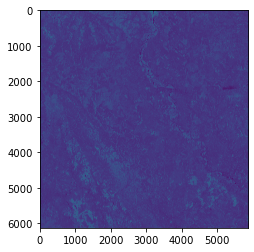

0'th dataset is created


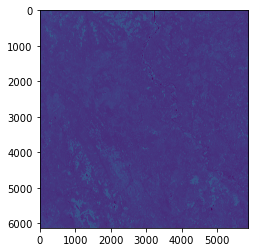

Остались чёрные края, увеличьте delta в функции crop_black!
1'th dataset is added


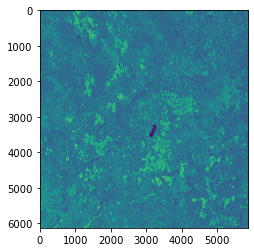

Остались чёрные края, увеличьте delta в функции crop_black!
2'th dataset is added


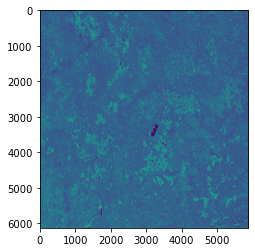

Остались чёрные края, увеличьте delta в функции crop_black!
3'th dataset is added


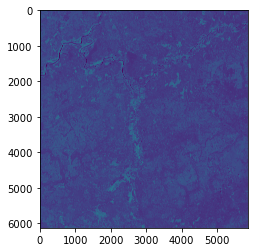

Остались чёрные края, увеличьте delta в функции crop_black!
4'th dataset is added


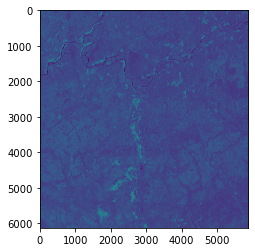

5'th dataset is added


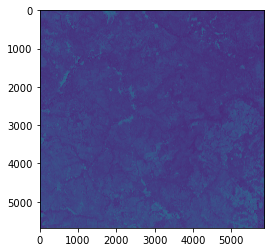

Остались чёрные края, увеличьте delta в функции crop_black!
6'th dataset is added


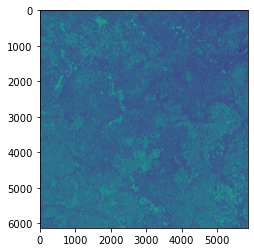

Остались чёрные края, увеличьте delta в функции crop_black!
7'th dataset is added


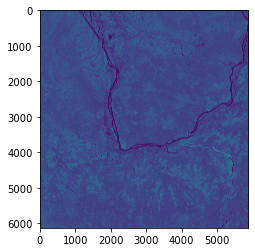

Остались чёрные края, увеличьте delta в функции crop_black!
8'th dataset is added


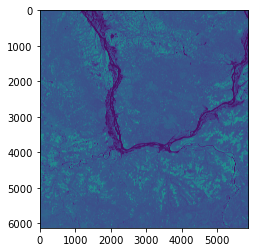

9'th dataset is added


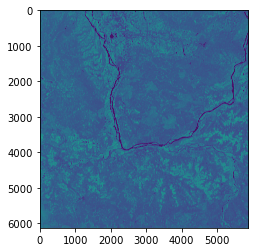

Остались чёрные края, увеличьте delta в функции crop_black!
10'th dataset is added


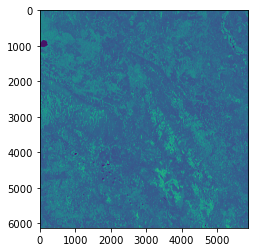

Остались чёрные края, увеличьте delta в функции crop_black!
11'th dataset is added


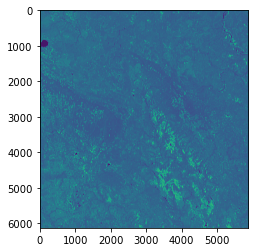

12'th dataset is added


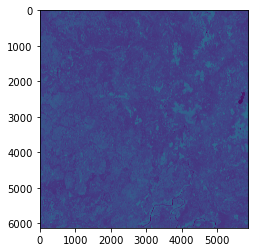

13'th dataset is added


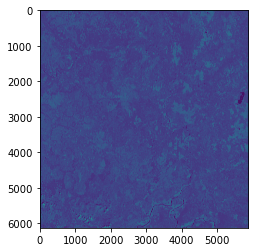

Остались чёрные края, увеличьте delta в функции crop_black!
14'th dataset is added


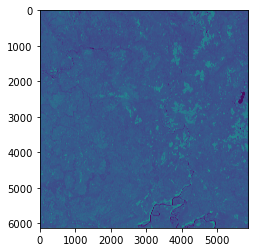

Остались чёрные края, увеличьте delta в функции crop_black!
15'th dataset is added


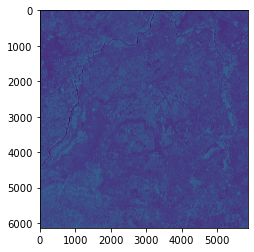

Остались чёрные края, увеличьте delta в функции crop_black!
16'th dataset is added


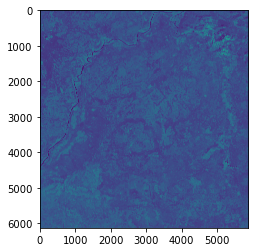

Остались чёрные края, увеличьте delta в функции crop_black!
17'th dataset is added


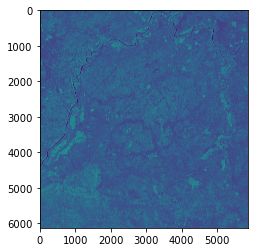

Остались чёрные края, увеличьте delta в функции crop_black!
18'th dataset is added


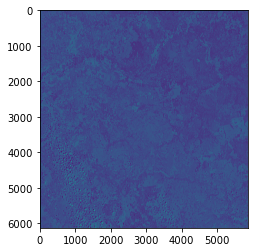

Остались чёрные края, увеличьте delta в функции crop_black!
19'th dataset is added


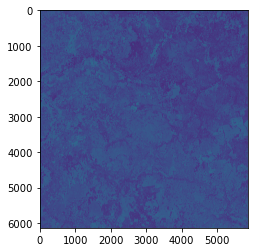

20'th dataset is added


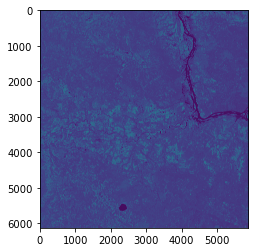

21'th dataset is added


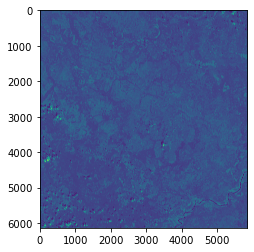

Остались чёрные края, увеличьте delta в функции crop_black!
22'th dataset is added


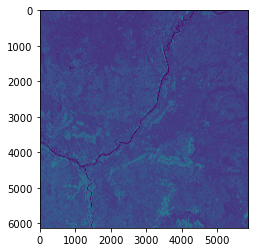

Остались чёрные края, увеличьте delta в функции crop_black!
23'th dataset is added


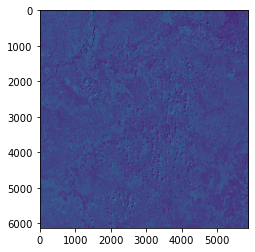

Остались чёрные края, увеличьте delta в функции crop_black!
24'th dataset is added


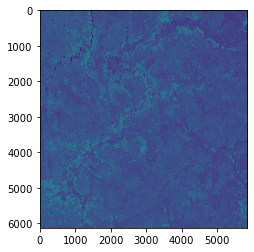

Остались чёрные края, увеличьте delta в функции crop_black!
25'th dataset is added


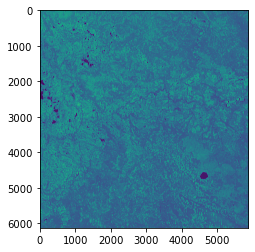

26'th dataset is added


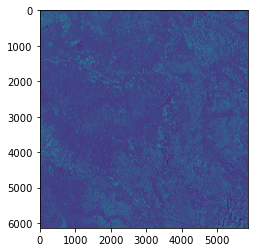

Остались чёрные края, увеличьте delta в функции crop_black!
27'th dataset is added


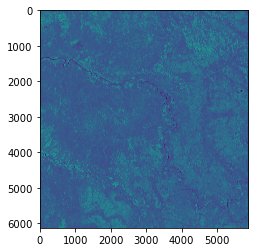

Остались чёрные края, увеличьте delta в функции crop_black!
28'th dataset is added


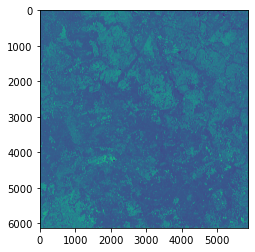

29'th dataset is added


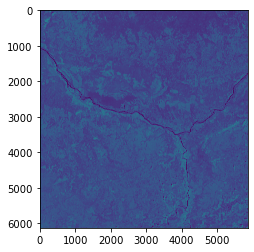

Остались чёрные края, увеличьте delta в функции crop_black!
30'th dataset is added


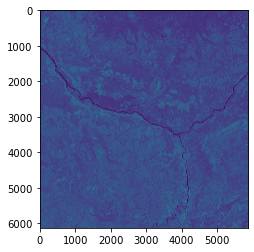

Остались чёрные края, увеличьте delta в функции crop_black!
31'th dataset is added


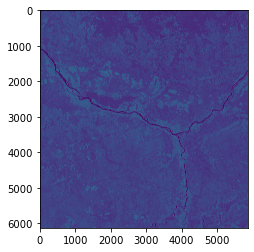

Остались чёрные края, увеличьте delta в функции crop_black!
32'th dataset is added


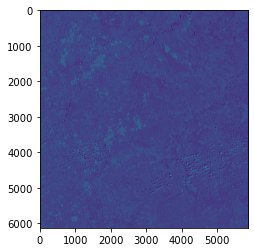

Остались чёрные края, увеличьте delta в функции crop_black!
33'th dataset is added


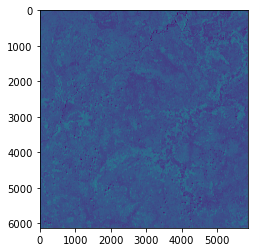

Остались чёрные края, увеличьте delta в функции crop_black!
34'th dataset is added


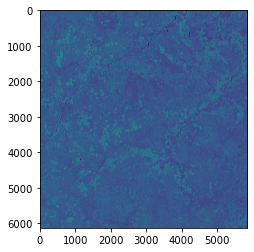

Остались чёрные края, увеличьте delta в функции crop_black!
35'th dataset is added


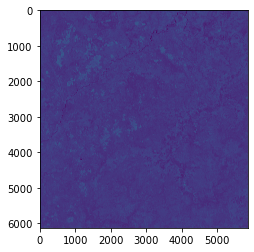

Остались чёрные края, увеличьте delta в функции crop_black!
36'th dataset is added


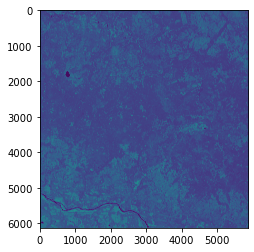

37'th dataset is added


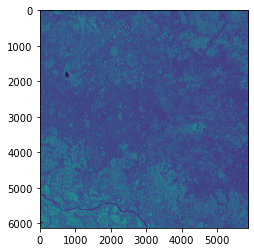

38'th dataset is added


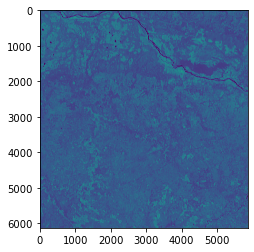

39'th dataset is added


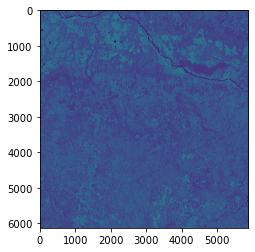

Остались чёрные края, увеличьте delta в функции crop_black!
40'th dataset is added


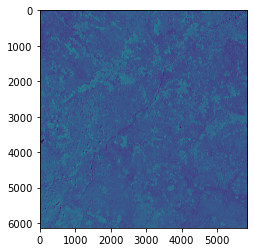

Остались чёрные края, увеличьте delta в функции crop_black!
41'th dataset is added


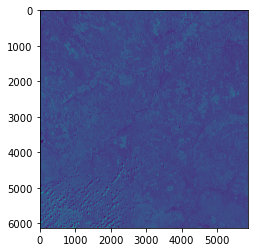

Остались чёрные края, увеличьте delta в функции crop_black!
42'th dataset is added


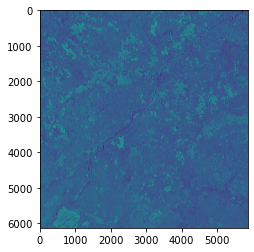

Остались чёрные края, увеличьте delta в функции crop_black!
43'th dataset is added


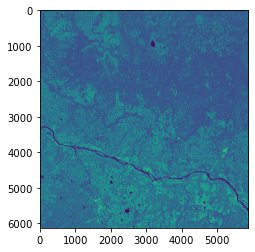

44'th dataset is added


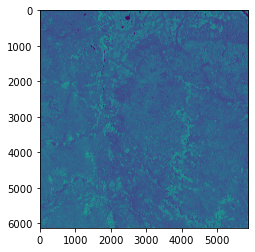

Остались чёрные края, увеличьте delta в функции crop_black!
45'th dataset is added


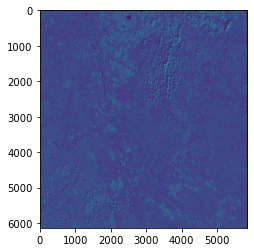

Остались чёрные края, увеличьте delta в функции crop_black!
46'th dataset is added


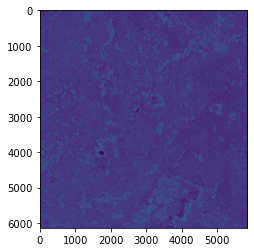

Остались чёрные края, увеличьте delta в функции crop_black!
47'th dataset is added


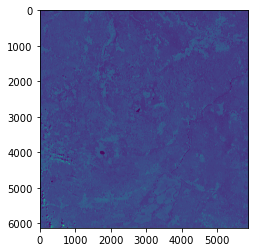

Остались чёрные края, увеличьте delta в функции crop_black!
48'th dataset is added


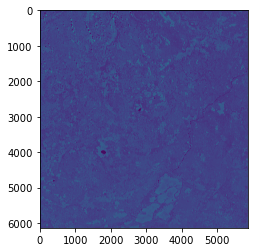

Остались чёрные края, увеличьте delta в функции crop_black!
49'th dataset is added


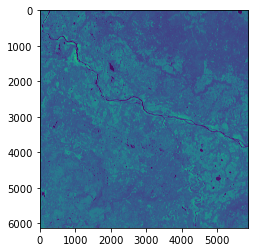

50'th dataset is added


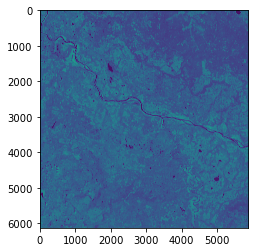

Остались чёрные края, увеличьте delta в функции crop_black!
51'th dataset is added


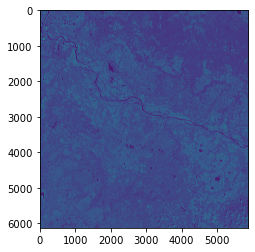

Остались чёрные края, увеличьте delta в функции crop_black!
52'th dataset is added


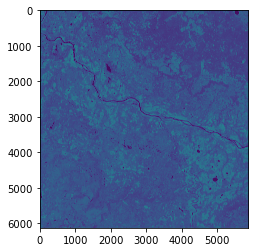

53'th dataset is added


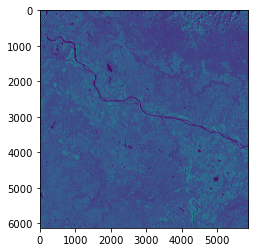

Остались чёрные края, увеличьте delta в функции crop_black!
54'th dataset is added


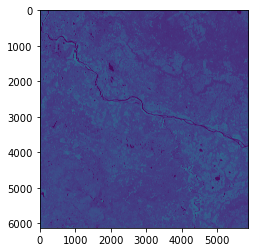

Остались чёрные края, увеличьте delta в функции crop_black!
55'th dataset is added


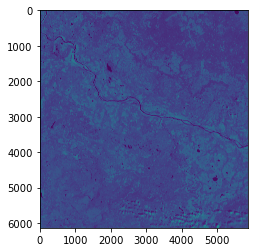

Остались чёрные края, увеличьте delta в функции crop_black!
56'th dataset is added


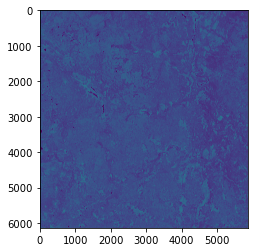

Остались чёрные края, увеличьте delta в функции crop_black!
57'th dataset is added


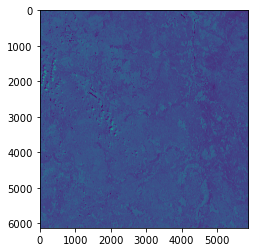

Остались чёрные края, увеличьте delta в функции crop_black!
58'th dataset is added


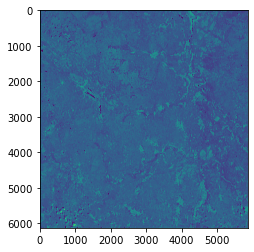

Остались чёрные края, увеличьте delta в функции crop_black!
59'th dataset is added


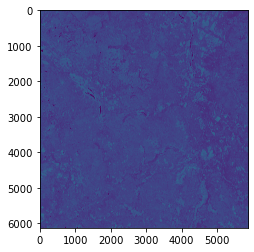

Остались чёрные края, увеличьте delta в функции crop_black!
60'th dataset is added


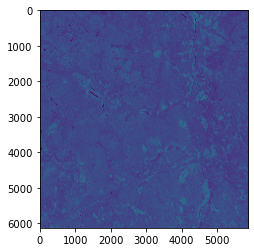

Остались чёрные края, увеличьте delta в функции crop_black!
61'th dataset is added


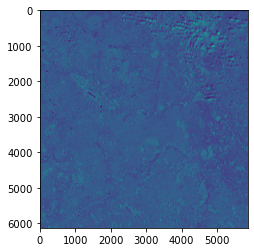

Остались чёрные края, увеличьте delta в функции crop_black!
62'th dataset is added


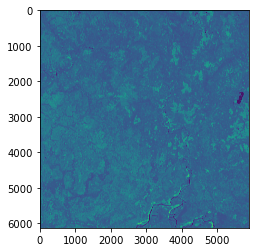

63'th dataset is added


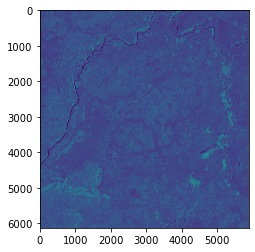

Остались чёрные края, увеличьте delta в функции crop_black!
64'th dataset is added


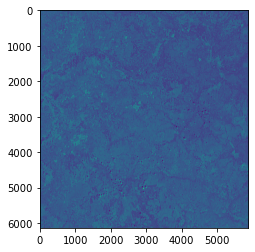

Остались чёрные края, увеличьте delta в функции crop_black!
65'th dataset is added


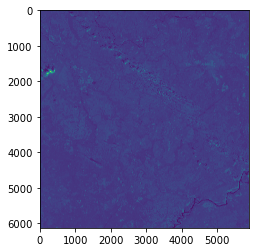

Остались чёрные края, увеличьте delta в функции crop_black!
66'th dataset is added


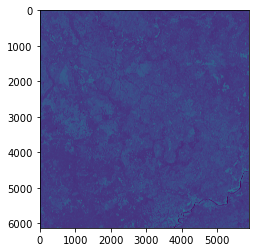

Остались чёрные края, увеличьте delta в функции crop_black!
67'th dataset is added


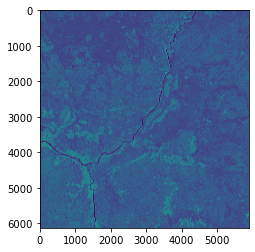

Остались чёрные края, увеличьте delta в функции crop_black!
68'th dataset is added


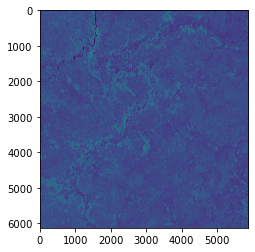

Остались чёрные края, увеличьте delta в функции crop_black!
69'th dataset is added


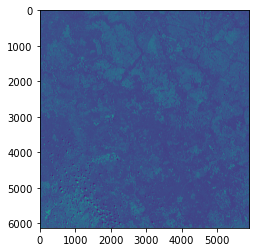

Остались чёрные края, увеличьте delta в функции crop_black!
70'th dataset is added


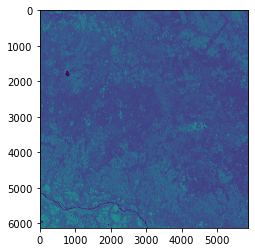

71'th dataset is added


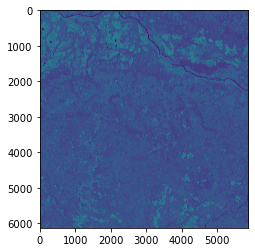

Остались чёрные края, увеличьте delta в функции crop_black!
72'th dataset is added


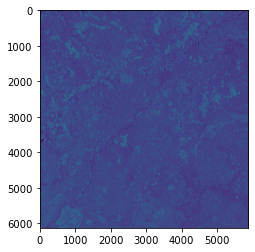

Остались чёрные края, увеличьте delta в функции crop_black!
73'th dataset is added


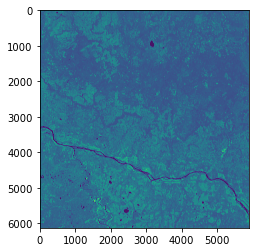

74'th dataset is added


In [25]:
path_to_h5 = './data/' + 'LC08_L2SP_02_T1_cropped.h5'
path_to_data = './data/images'
scenes = sorted(os.listdir(path_to_data))
size = 512
with h5.File(path_to_h5, 'w') as f:
    SUM = 0
    for n,s in enumerate(scenes):
        image = numpy_image(s, path_to_data)
        plt.imshow(image.npy[:,:,4])
        plt.show()
        if len(np.where(image.npy == 0)[0])>0:
            print('Остались чёрные края, увеличьте delta в функции crop_black!')
        batch, coords = image.make_cropped_batch(size)
        SUM += np.sum(batch, axis = (0,1,2))
        #batch = (batch-mean)/disp
        if n == 0:
            f.create_dataset('all/data_raw', data=batch, maxshape=(None,size,size,7))
            f.create_dataset('all/geo_coords', data=coords, maxshape=(None,2))
            print(str(n)+"'th dataset is created")
        else:
            f['all/data_raw'].resize((f['all/data_raw'].shape[0] + batch.shape[0]), axis = 0)
            f['all/data_raw'][-batch.shape[0]:] = batch
            f['all/geo_coords'].resize((f['all/geo_coords'].shape[0] + coords.shape[0]), axis = 0)
            f['all/geo_coords'][-coords.shape[0]:] = coords
            print(str(n)+"'th dataset is added")

## Нормировка

In [28]:
path_to_h5 = './data/' + 'LC08_L2SP_02_T1_cropped.h5'
with h5.File(path_to_h5, 'r') as f:
    SUM = 0
    SUM_SQ = 0
    N = f['all/data_raw'].shape[0]
    #N = 100
    size = f['all/data_raw'].shape[1]
    for n,i in enumerate(range(0,N,75)):
        SUM += np.sum(f['all/data_raw'][i:i+25], axis = (0,1,2))
        if i%100 == 0: print('Batch number is:', i)
    MEAN = np.array(SUM, dtype = 'float64')/(N*size**2)
    for n,i in enumerate(range(0,N,25)):
        SUM_SQ += np.sum((f['all/data_raw'][i:i+25]-MEAN)**2, axis = (0,1,2))
        DISP = SUM_SQ/(N*size**2)
        SIGMA = np.sqrt(DISP)
        if i%100 == 0: print('Batch number is:', i)
    f.create_dataset('all/norm_params/mean_values', data=MEAN, maxshape=(7,))
    f.create_dataset('all/norm_params/sigma_values', data=SIGMA, maxshape=(7,))

Batch number is: 0
Batch number is: 100
Batch number is: 200
Batch number is: 300
Batch number is: 400
Batch number is: 500
Batch number is: 600
Batch number is: 700
Batch number is: 800
Batch number is: 900
Batch number is: 1000
Batch number is: 1100
Batch number is: 1200
Batch number is: 1300
Batch number is: 1400
Batch number is: 1500
Batch number is: 1600
Batch number is: 1700
Batch number is: 1800
Batch number is: 1900
Batch number is: 2000
Batch number is: 2100
Batch number is: 2200
Batch number is: 2300
Batch number is: 2400
Batch number is: 2500
Batch number is: 2600
Batch number is: 2700
Batch number is: 2800
Batch number is: 2900
Batch number is: 3000
Batch number is: 3100
Batch number is: 3200
Batch number is: 3300
Batch number is: 3400
Batch number is: 3500
Batch number is: 3600
Batch number is: 3700
Batch number is: 3800
Batch number is: 3900
Batch number is: 4000
Batch number is: 4100
Batch number is: 4200
Batch number is: 4300
Batch number is: 4400
Batch number is: 4500


In [84]:
with h5.File(path_to_h5, 'r+') as f:
    MEAN = f['all/norm_params/mean_values']
    SIGMA = f['all/norm_params/sigma_values']
    N = f['all/data_raw'].shape[0] # N == 9075 is True
    size = f['all/data_raw'].shape[1]
    bs = 9075//25
    for i in range(0,N,bs):
        batch = np.array(f['all/data_raw'][i:i+bs], dtype = 'float64')
        batch_norm = np.array((batch-MEAN)/SIGMA, dtype = 'float32')
        if i == 0:
            f.create_dataset('all/data_norm', data=batch_norm, maxshape=(None,size,size,7))
        else:
            f['all/data_norm'].resize((f['all/data_norm'].shape[0] + bs), axis = 0)
            f['all/data_norm'][-bs:] = batch_norm
        print('Batch number is: ', i)

Batch number is:  0
Batch number is:  363
Batch number is:  726
Batch number is:  1089
Batch number is:  1452
Batch number is:  1815
Batch number is:  2178
Batch number is:  2541
Batch number is:  2904
Batch number is:  3267
Batch number is:  3630
Batch number is:  3993
Batch number is:  4356
Batch number is:  4719
Batch number is:  5082
Batch number is:  5445
Batch number is:  5808
Batch number is:  6171
Batch number is:  6534
Batch number is:  6897
Batch number is:  7260
Batch number is:  7623
Batch number is:  7986
Batch number is:  8349
Batch number is:  8712


In [86]:
with h5.File(path_to_h5, 'r+') as f:
    print(f['all/data_norm'][0:10].dtype)

float32


## Делаем маленький h5 файл

In [6]:
path_to_h5_small = './data/' + 'LC08_L2SP_02_T1_cropped_small.h5'
with h5.File(path_to_h5_small, 'w') as fs:
    with h5.File(path_to_h5, 'r') as f:
        N,size = f['all/data_norm'].shape[0:2]
        N_small = N//9
        bs = 112
        for i in range(0,N_small,bs):
            batch = f['all/data_norm'][i:i+bs]
            coords = f['all/geo_coords'][i:i+bs]
            if i == 0:
                fs.create_dataset('all/data_norm', data=batch, maxshape=(None,size,size,7))
                fs.create_dataset('all/geo_coords', data=coords, maxshape=(None,2))
            else:
                fs['all/data_norm'].resize((fs['all/data_norm'].shape[0] + bs), axis = 0)
                fs['all/data_norm'][-bs:] = batch
                
                fs['all/geo_coords'].resize((fs['all/geo_coords'].shape[0] + bs), axis = 0)
                fs['all/geo_coords'][-bs:] = coords
            print('Batch number is: ', i)
        MEAN = f['all/norm_params/mean_values']
        SIGMA = f['all/norm_params/sigma_values']
        fs.create_dataset('all/norm_params/mean_values', data=MEAN, maxshape=(7,))
        fs.create_dataset('all/norm_params/sigma_values', data=SIGMA, maxshape=(7,))

Batch number is:  0
Batch number is:  112
Batch number is:  224
Batch number is:  336
Batch number is:  448
Batch number is:  560
Batch number is:  672
Batch number is:  784
Batch number is:  896


In [92]:
N//9

1008

In [97]:
1008/9

112.0

In [37]:
channel_list = []
with h5.File(path_to_h5_small, 'r') as fs:
    for i in range(7):
        channel_list.append(fs['all/data_norm'][0:50,:,:,i].flatten())

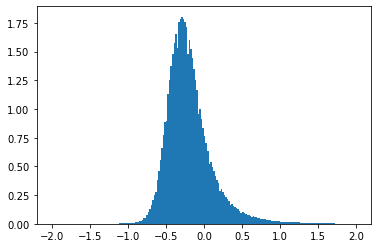

In [38]:
plt.hist(channel_list[0], bins = 200, range = (-2,2), density = True)
plt.show()

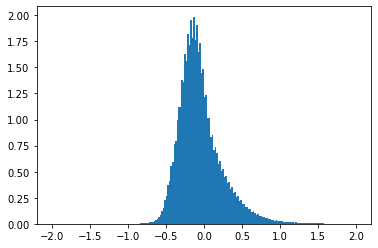

In [39]:
plt.hist(channel_list[1], bins = 200, range = (-2,2), density = True)
plt.show()

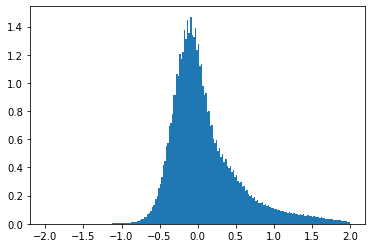

In [40]:
plt.hist(channel_list[2], bins = 200, range = (-2,2), density = True)
plt.show()

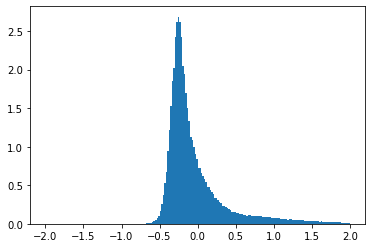

In [41]:
plt.hist(channel_list[3], bins = 200, range = (-2,2), density = True)
plt.show()

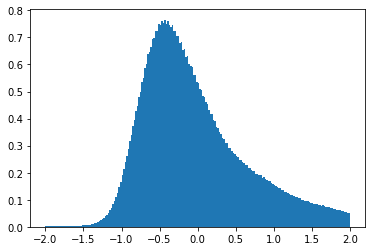

In [42]:
plt.hist(channel_list[4], bins = 200, range = (-2,2), density = True)
plt.show()

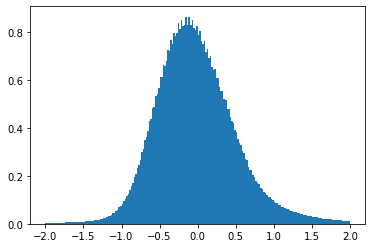

In [43]:
plt.hist(channel_list[5], bins = 200, range = (-2,2), density = True)
plt.show()

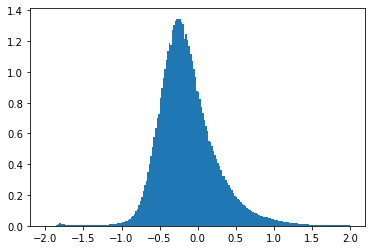

In [44]:
plt.hist(channel_list[6], bins = 200, range = (-2,2), density = True)
plt.show()